# Plots and analysis
This notebook contains plots and other code to explore guesses of the players of the game.

### Table of Content:

* [Ground truth related stats](#ground-truth-stats)
* [Appendix](#appendix)

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%run ./prepare_data.ipynb
from data.prepdata import *

['URL11', 'URL10', 'URL6']


# Statistics

## Guesses stats

### Most popular and least votes

In [2]:
# code from https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675
# function creating leaderboard

def create_leaderboard(df,col_name, tab_header):
    leaderboard = df[col_name].value_counts(ascending=True)
    s = pd.Series(leaderboard, name=tab_header)
    df2 = s.to_frame().sort_values(tab_header, ascending=False)
    return df2

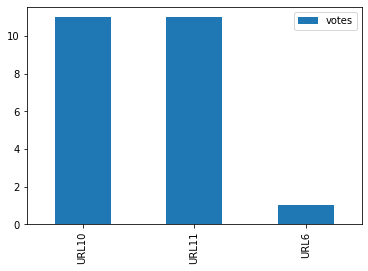

In [3]:
# total number of votes per link
votes_links = create_leaderboard(df_raw,'Current URL','votes')
votes_links.plot.bar(y='votes'); # plot histogram


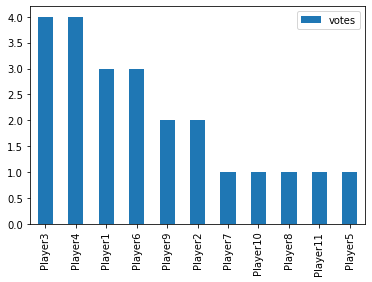

In [4]:
# total votes for each player

total_votes = create_leaderboard(df_raw,'Guess','votes')
total_votes.plot.bar(y='votes'); # plot histogram

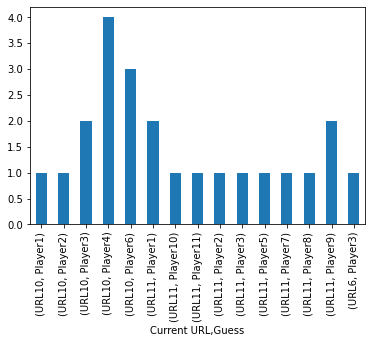

In [5]:
# stats of guesses per URL

guess_stats = df_raw.groupby(by=['Current URL', 'Guess'])['Guess'].count()
s = pd.Series(guess_stats, name="votes")
df_guess = s.to_frame().sort_values("votes", ascending=False).reset_index()
guess_stats.plot.bar(x='Current URL'); # plot histogram


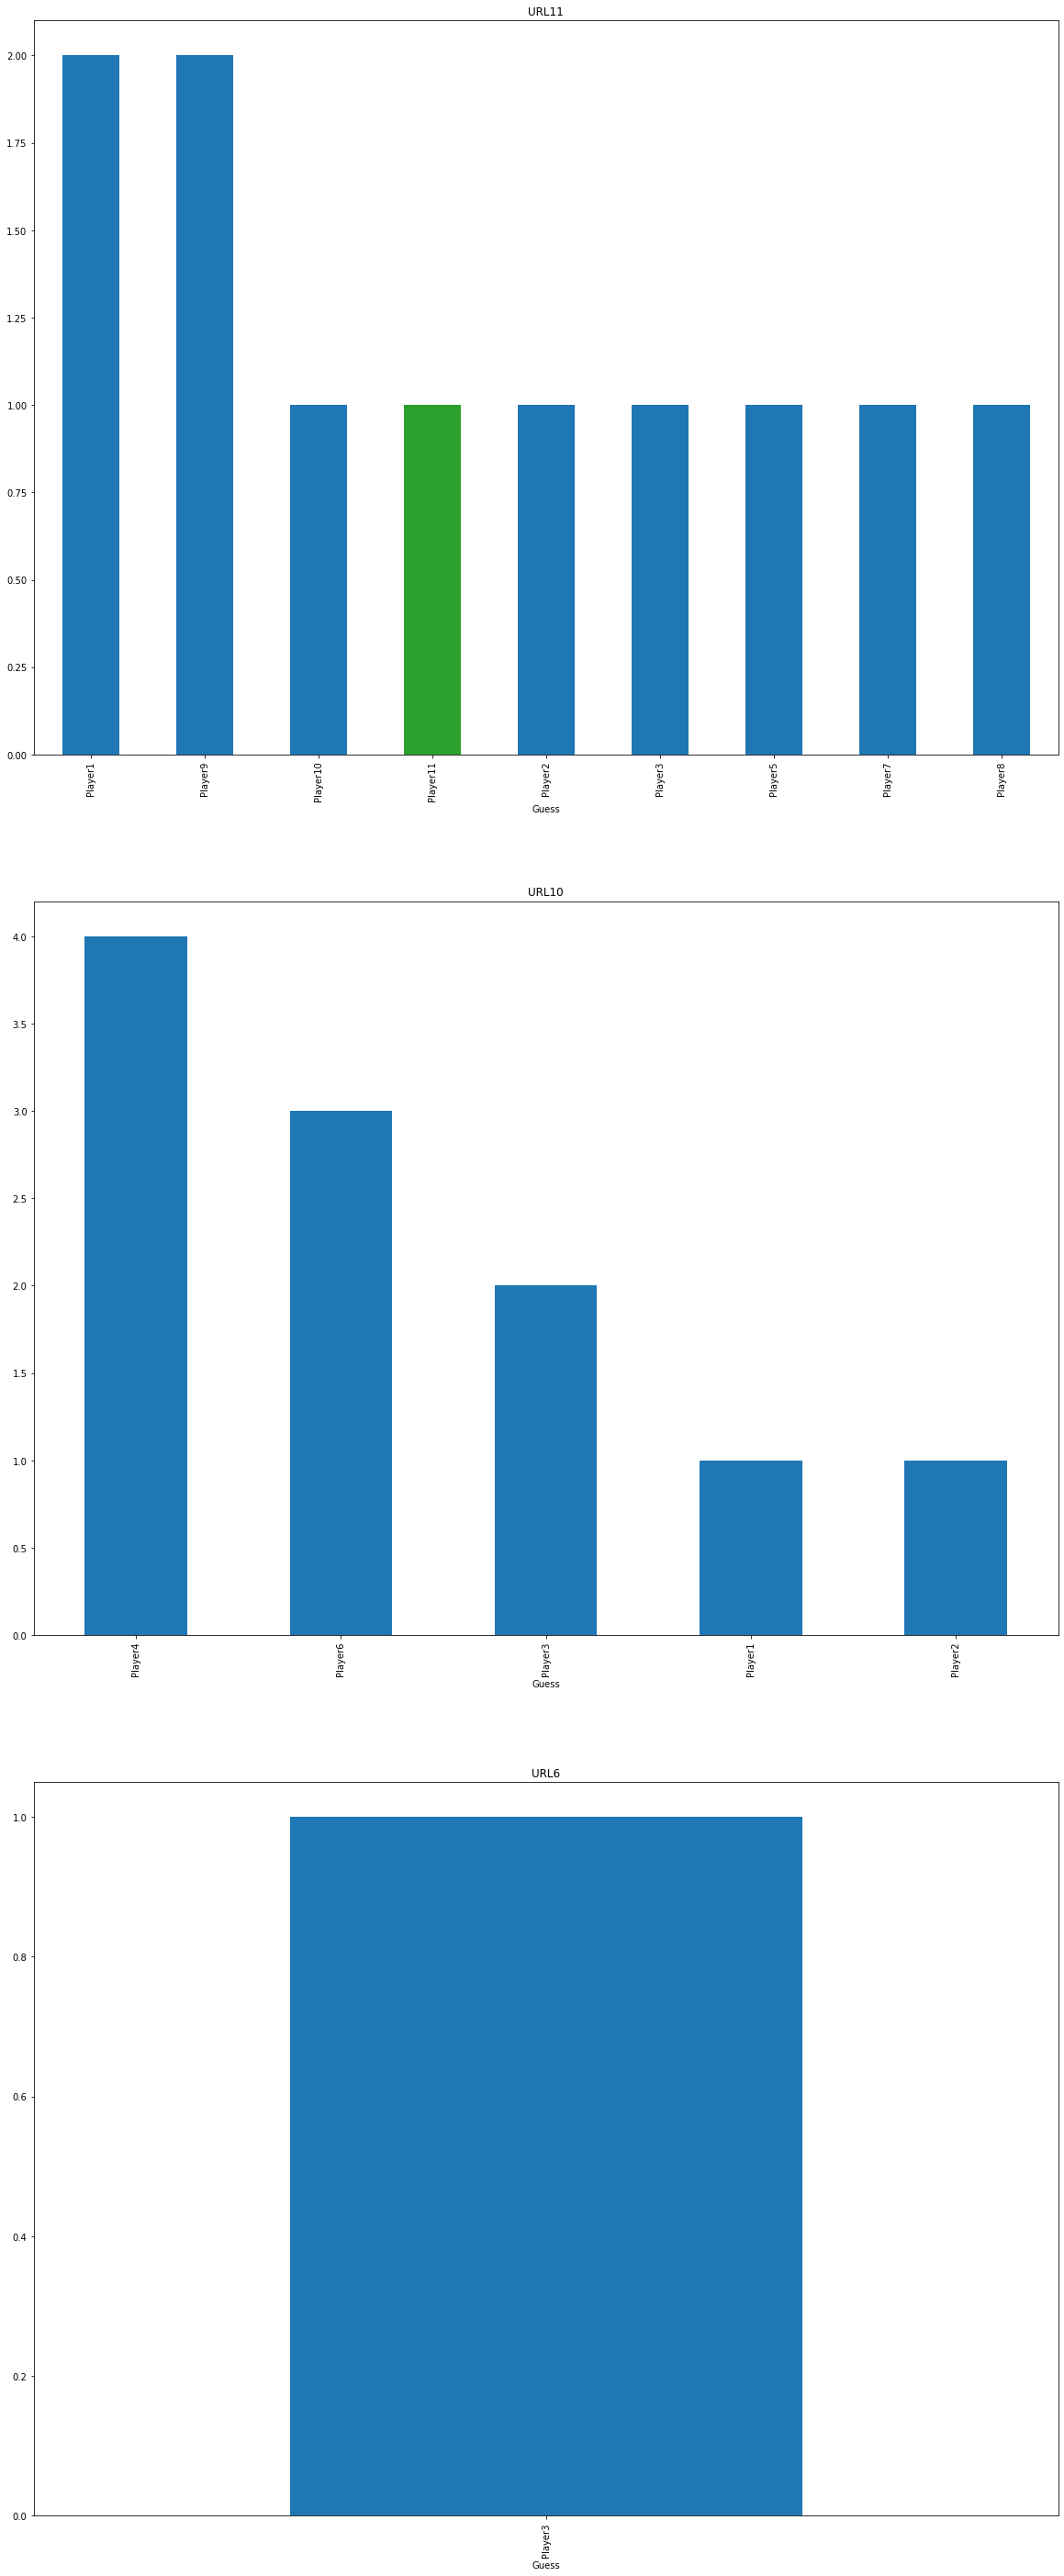

In [6]:
# bar chart per URL, the correct answer is colored in green, the rest of the guesses are blue

fig, axes = plt.subplots(len(urls),1,figsize=(20, 50)) #ncols=len(urls)#,)
for i,ax in enumerate(axes):
    url = urls[i]
    temp_df = df_guess.loc[df_guess['Current URL'] == url]
    labels = temp_df['Guess']
    cor_ans = df2_raw[df2_raw['URL'] == url]['Player'].values[0]
    ind=labels.isin([cor_ans])
    color=list(map(lambda x: 'C2' if x else 'C0', ind))
    temp_df.loc[:,['Guess','votes']].plot.bar(ax=ax,subplots=True, x='Guess',y='votes',color=color);
    ax.get_legend().remove()
    ax.set_title(url)
plt.show()



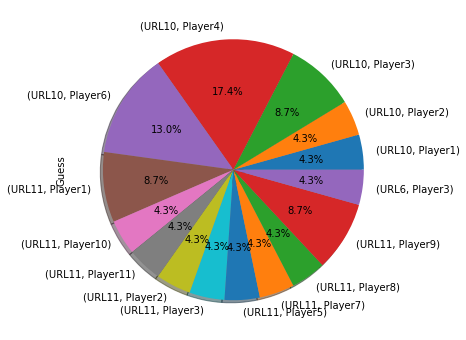

In [7]:
# combined pie chart
guess_stats.plot.pie(subplots=True,y='votes',figsize=(6, 6),autopct='%1.1f%%',shadow = True);

In [8]:
print(df_guess.columns)

Index(['Current URL', 'Guess', 'votes'], dtype='object')


In [9]:
df = df_guess.loc[df_guess['Current URL'] == 'URL6']
df.loc[:,['Guess','votes']]

,Guess,votes
14,Player3,1


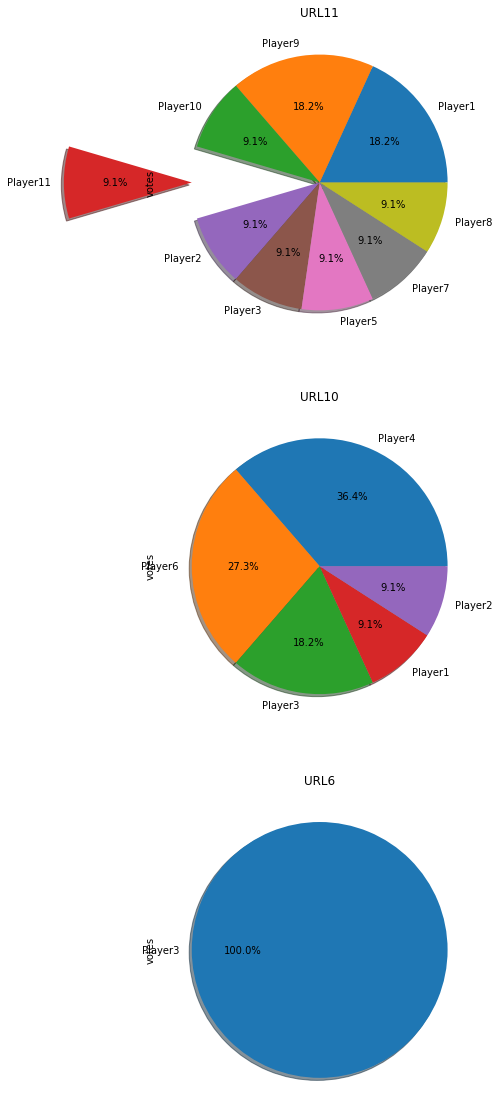

In [10]:
#FIXME: position of correct answer
fig, axes = plt.subplots(len(urls),1,figsize=(30, 20)) #ncols=len(urls)#,)
for i,ax in enumerate(axes):
    url = urls[i]
    temp_df = df_guess.loc[df_guess['Current URL'] == url]
    labels = temp_df['Guess']
    cor_ans = df2_raw[df2_raw['URL'] == url]['Player'].values[0]
    ind=labels.isin([cor_ans])
    explode=list(map(int, ind))
    temp_df.loc[:,['Guess','votes']].plot.pie(ax=ax,subplots=True,labels = labels, y='votes', autopct='%1.1f%%',shadow = True,explode=explode);
    ax.get_legend().remove()
    ax.set_title(url)
plt.show()


## Ground truth related stats <a class="anchor" id="ground-truth-stats"></a>

### TBD

In [11]:
#TODO

# Appendix: Graphs <a class="anchor" id="appendix"></a>

In [12]:
# first dumb graph, ignores weights
G = nx.from_pandas_edgelist(df_raw, 'Player', 'Guess',)

# and now we try multigraph
M = nx.from_pandas_edgelist(df_raw, 'Player', 'Guess', create_using=nx.MultiDiGraph())


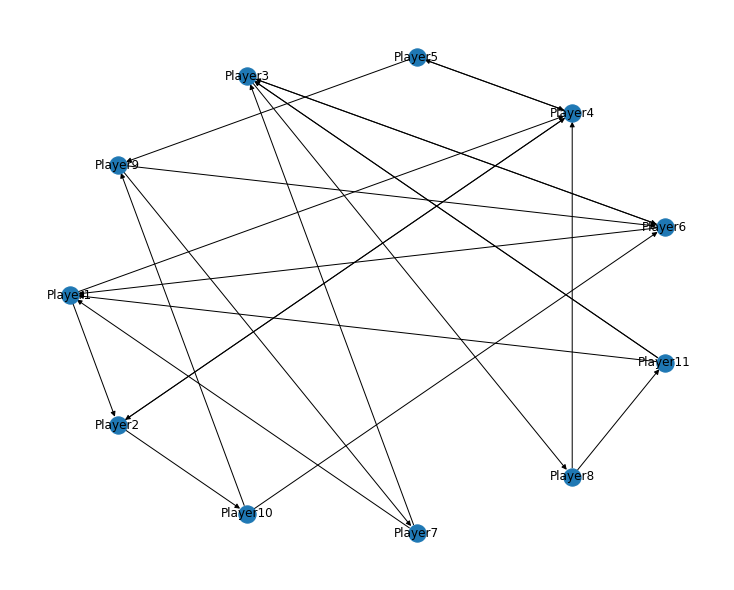

In [13]:
# plot spacy multigraph of who voted for whom
plt.figure(figsize=(10, 8))
nx.draw_shell(M, with_labels=True)

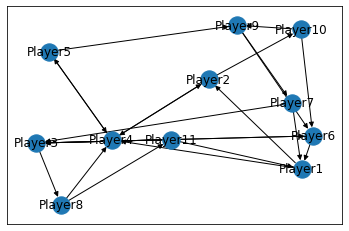

In [14]:
# a bit more dense
nx.draw_networkx(M)

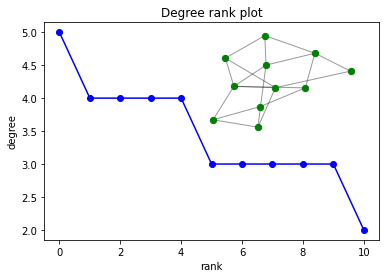

In [15]:
# another look via degree sequences
# source: from networkx gallery

degree_dist = sorted([vote for player, vote in G.degree()], reverse=True)
dmax = max(degree_dist)

plt.plot(degree_dist, "b-", marker="o")
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
# not implemented for directed graph?
plt.axes([0.5, 0.5, 0.35, 0.35])
g_cc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=False)[0])
pos = nx.spring_layout(g_cc)
plt.axis("off")
nx.draw_networkx_nodes(g_cc, pos, node_size=40, node_color="green")
nx.draw_networkx_edges(g_cc, pos, arrowstyle="->", arrowsize=10, alpha=0.4)